# Lab 2

In [9]:
import utils as ut
import numpy as np
import matplotlib.pyplot as plt
import glob
import math
import pandas as pd


In [95]:
df = pd.read_csv('Lab2_data/Helium.csv', usecols=[0,1], skiprows=53)
print(df)
type(df)

         Pixel Number  Measured Signal
0     3.209201965e+02        -0.000100
1     3.210282593e+02        -0.001163
2     3.211363220e+02         0.000698
3     3.212443848e+02         0.000736
4     3.213524780e+02         0.000698
...               ...              ...
3644  7.429968262e+02        -0.002645
3645  7.431162720e+02        -0.001562
3646  7.432357178e+02        -0.001695
3647  7.433551636e+02        -0.001885
3648      [EndOfFile]              NaN

[3649 rows x 2 columns]


pandas.core.frame.DataFrame

In [96]:
print(df['Pixel Number'])

0       3.209201965e+02
1       3.210282593e+02
2       3.211363220e+02
3       3.212443848e+02
4       3.213524780e+02
             ...       
3644    7.429968262e+02
3645    7.431162720e+02
3646    7.432357178e+02
3647    7.433551636e+02
3648        [EndOfFile]
Name: Pixel Number, Length: 3649, dtype: object


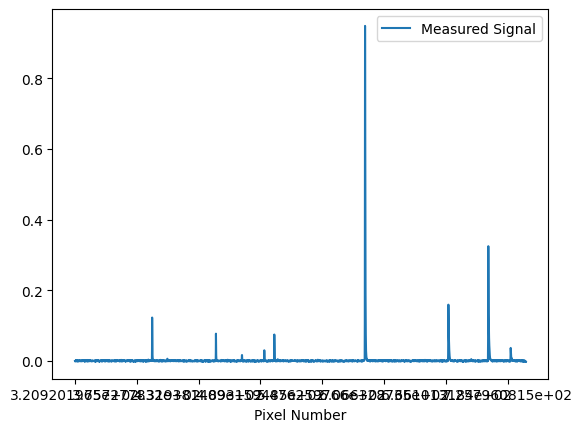

In [97]:
df.plot(x='Pixel Number', y='Measured Signal')
plt.show()

In [90]:
files = glob.glob('Lab2_data/*.csv')
print(files)

['Lab2_data/Mercury.csv', 'Lab2_data/Helium.csv', 'Lab2_data/lamp.csv', 'Lab2_data/Neon.csv', 'Lab2_data/fluorescent.csv', 'Lab2_data/Hydrogen.csv']


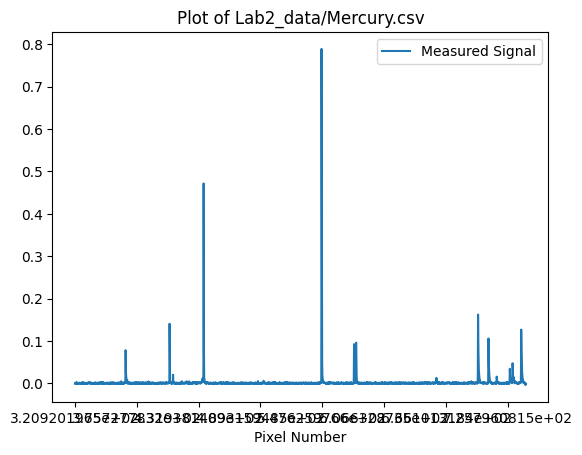

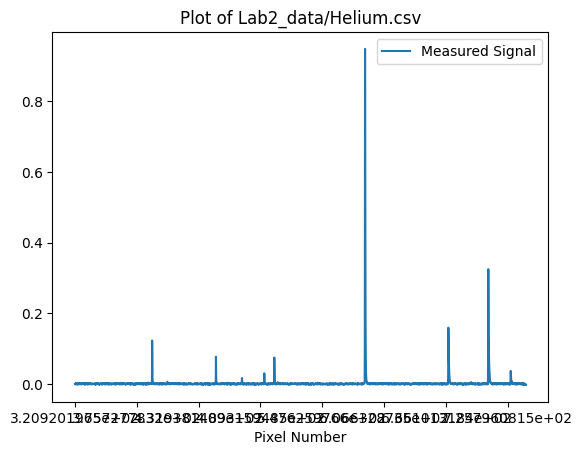

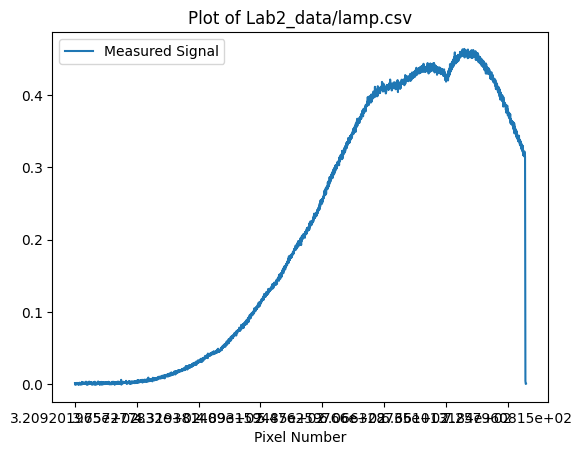

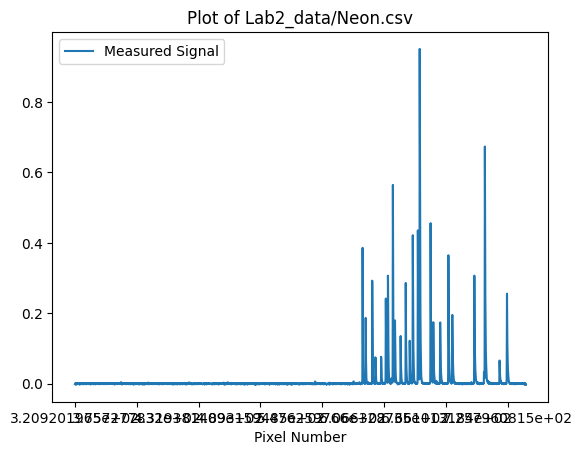

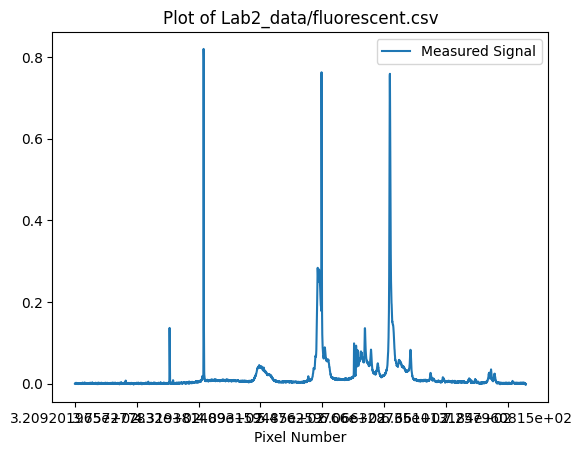

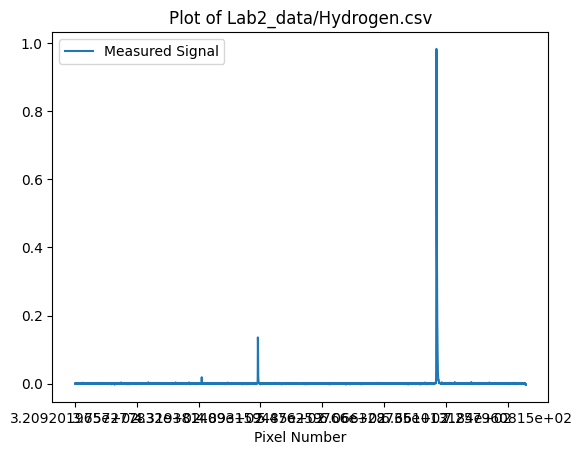

In [100]:
for i, file in enumerate(files):
    idx = int(i)
    df = pd.read_csv(file, usecols=[0,1], skiprows=53)
    df.plot(x='Pixel Number', y='Measured Signal')
    plt.title(f'Plot of {files[idx]}')
    plt.show()